In [ ]:
!pip install pyspark==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285391 sha256=9630a8ce342abfa6bed213d3d0a320756db3dd00a11b8ab4c08fdf9931a8d51e
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


# Tugas 1

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('HandsOnPertemuan9').getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



# Tugas 2

In [ ]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [ ]:
spark.sql('''
SELECT DeptId, AVG(Salary) as AVGSalary
FROM employees
GROUP BY DeptId
''').show()

+------+---------+
|DeptId|AVGSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [ ]:
spark.sql('''
WITH AvgGenderSalary AS (
    SELECT Gender, AVG(Salary) as AvgSalary
    FROM employees
    GROUP BY Gender
)
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN AvgGenderSalary ags
ON e.Gender = ags.Gender
WHERE e.Salary > ags.AvgSalary
''').show()

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+



In [ ]:
spark.sql('''
SELECT Name, DeptId, Salary,
      DENSE_RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as SalaryRank
FROM employees
''').show()

+-----+------+------+----------+
| Name|DeptId|Salary|SalaryRank|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



In [ ]:
spark.sql('''
SELECT * FROM employees e
WHERE Salary > (
  SELECT AVG(Salary)
  FROM employees
  WHERE Gender = e.Gender )
''').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
+-----+---+------+------+------+



# Tugas 3

In [ ]:
spark.sql('''
WITH RankedEmployees AS ( SELECT *, ROW_NUMBER() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as Rank FROM employees)
SELECT * FROM RankedEmployees
''').show()

+-----+---+------+------+------+----+
| Name|Age|Gender|Salary|DeptId|Rank|
+-----+---+------+------+------+----+
|James| 34|     M|  3000|     1|   1|
|  Lee| 23|     M|  2700|     1|   2|
| Anna| 28|     F|  4100|     2|   1|
+-----+---+------+------+------+----+



In [ ]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC)as rank
FROM employees
WHERE AGE < 34
''').show()

+----+---+------+----+
|Name|Age|Salary|rank|
+----+---+------+----+
| Lee| 23|  2700|   1|
|Anna| 28|  4100|   1|
+----+---+------+----+



# Tugas 4

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



# Tugas 5

In [ ]:
# SQL query for average salary per department and employee ranking
spark.sql('''
SELECT e.Name, e.Salary, e.DeptId, d.DeptName,
       AVG(e.Salary) OVER (PARTITION BY e.DeptId) as AvgSalary,
       DENSE_RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) as SalaryRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

+-----+------+------+---------+---------+----------+
| Name|Salary|DeptId| DeptName|AvgSalary|SalaryRank|
+-----+------+------+---------+---------+----------+
|James|  3000|     1|       HR|   2850.0|         1|
|  Lee|  2700|     1|       HR|   2850.0|         2|
| Anna|  4100|     2|Marketing|   4100.0|         1|
+-----+------+------+---------+---------+----------+



# Tugas 6

In [ ]:
# SQL query for ranking employees based on age within each department
spark.sql('''
SELECT e.Name, e.Age, e.Salary, e.DeptId, d.DeptName,
       DENSE_RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Age) as AgeRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

spark.sql('''
SELECT
    e.Name,
    e.Age,
    d.DeptName,
    e.Salary,
    AVG(e.Salary) OVER (PARTITION BY d.DeptName ORDER BY e.Age) AS avg_salary_by_age_in_dept
FROM
    employees e
JOIN
    departments d ON e.DeptId = d.DeptId
ORDER BY
    d.DeptName, e.Age;
''').show()

# SQL query for ranking employees based on age within each department
spark.sql('''
SELECT e.Name, e.Age, e.Salary, e.DeptId, d.DeptName,
       DENSE_RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary) as trend_age_rank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

+-----+---+------+------+---------+-------+
| Name|Age|Salary|DeptId| DeptName|AgeRank|
+-----+---+------+------+---------+-------+
|  Lee| 23|  2700|     1|       HR|      1|
|James| 34|  3000|     1|       HR|      2|
| Anna| 28|  4100|     2|Marketing|      1|
+-----+---+------+------+---------+-------+

+-----+---+---------+------+-------------------------+
| Name|Age| DeptName|Salary|avg_salary_by_age_in_dept|
+-----+---+---------+------+-------------------------+
|  Lee| 23|       HR|  2700|                   2700.0|
|James| 34|       HR|  3000|                   2850.0|
| Anna| 28|Marketing|  4100|                   4100.0|
+-----+---+---------+------+-------------------------+

+-----+---+------+------+---------+--------------+
| Name|Age|Salary|DeptId| DeptName|trend_age_rank|
+-----+---+------+------+---------+--------------+
|  Lee| 23|  2700|     1|       HR|             1|
|James| 34|  3000|     1|       HR|             2|
| Anna| 28|  4100|     2|Marketing|             1|

# Tugas 7

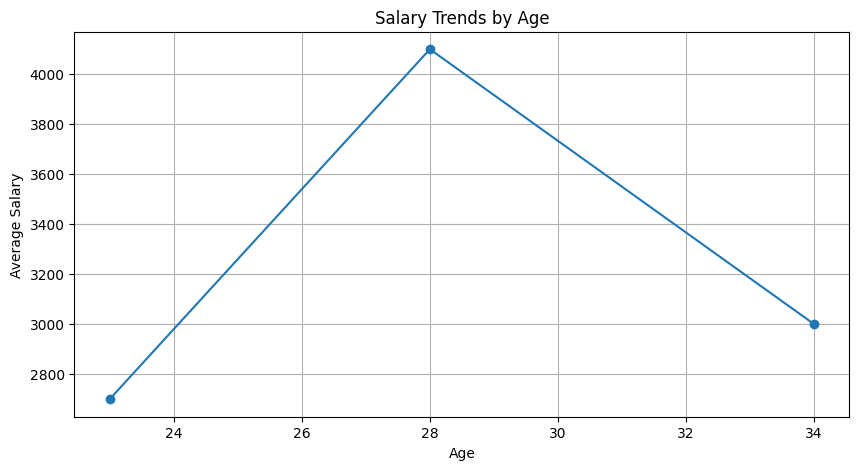

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').show()

+---+-------------+
|Age|AverageSalary|
+---+-------------+
| 23|       2700.0|
| 28|       4100.0|
| 34|       3000.0|
+---+-------------+



# Homework

## Tugas 1

In [ ]:
import pandas as pd

departemen_data = {
    'departemen': ['HR', 'IT', 'Finance', 'Sales'],
    'gaji': [60000, 80000, 70000, 50000],
    'jumlah_karyawan': [5, 8, 6, 7]
}

df_departemen = pd.DataFrame(departemen_data)

total_gaji_per_departemen = df_departemen.groupby('departemen')['gaji'].sum().reset_index()
jumlah_karyawan_per_departemen = df_departemen.groupby('departemen')['jumlah_karyawan'].sum().reset_index()

hasil_join = pd.merge(total_gaji_per_departemen, jumlah_karyawan_per_departemen, on='departemen')
hasil_join.columns = ['departemen', 'total_gaji', 'jumlah_karyawan']
print(hasil_join)

  departemen  total_gaji  jumlah_karyawan
0    Finance       70000                6
1         HR       60000                5
2         IT       80000                8
3      Sales       50000                7


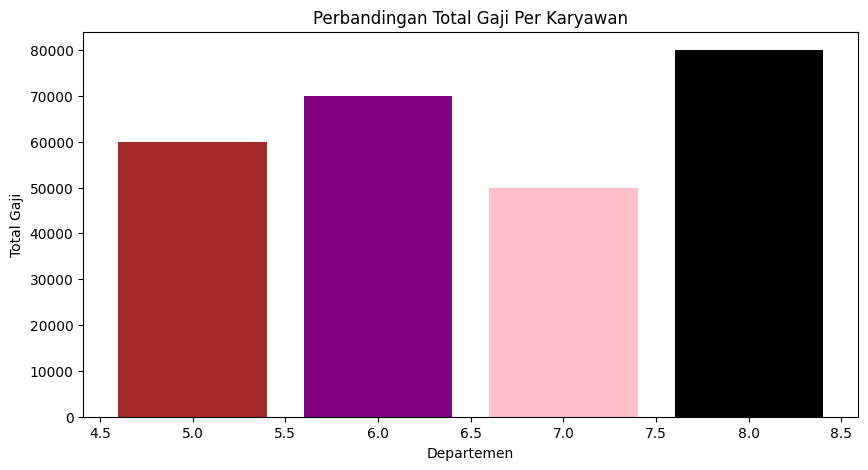

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the bar chart (from your previous code)
departemen_data = {
    'departemen': ['HR', 'IT', 'Finance', 'Sales'],
    'gaji': [60000, 80000, 70000, 50000],
    'jumlah_karyawan': [5, 8, 6, 7]
}

df_departemen = pd.DataFrame(departemen_data)

total_gaji_per_departemen = df_departemen.groupby('departemen')['gaji'].sum().reset_index()
jumlah_karyawan_per_departemen = df_departemen.groupby('departemen')['jumlah_karyawan'].sum().reset_index()

hasil_join = pd.merge(total_gaji_per_departemen, jumlah_karyawan_per_departemen, on='departemen')
hasil_join.columns = ['departemen', 'total_gaji', 'jumlah_karyawan']


# Now you can use hasil_join for the plot
labels = hasil_join['jumlah_karyawan']
sizes = hasil_join['total_gaji']

plt.figure(figsize=(10, 5))
plt.bar(labels, sizes, color=['purple', 'brown', 'black', 'pink'])
plt.xlabel('Departemen')
plt.ylabel('Total Gaji')
plt.title('Perbandingan Total Gaji Per Karyawan')

plt.show()

## Tugas 2

In [ ]:
import pandas as pd

# Contoh data
data = {
    'employee_id': [1, 2, 3, 4, 5, 6],
    'name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Frank'],
    'age_group': ['20-30', '20-30', '31-40', '31-40', '41-50', '41-50'],
    'salary': [5000, 7000, 8000, 6000, 9000, 12000],
    'department': ['IT', 'Finance', 'HR', 'IT', 'Sales', 'Finance']
}

df_employees = pd.DataFrame(data)

# Menghitung rata-rata gaji per kelompok usia
df_avg_salary = df_employees.groupby('age_group')['salary'].mean().reset_index()
df_avg_salary.columns = ['age_group', 'avg_salary']

# Gabungkan rata-rata gaji ke dalam DataFrame asli
df_merged = pd.merge(df_employees, df_avg_salary, on='age_group')

# Filter karyawan yang gajinya di atas rata-rata kelompok usia
df_above_avg = df_merged[df_merged['salary'] > df_merged['avg_salary']]
print(df_above_avg)

   employee_id     name age_group  salary department  avg_salary
1            2      Bob     20-30    7000    Finance      6000.0
2            3  Charlie     31-40    8000         HR      7000.0
5            6    Frank     41-50   12000    Finance     10500.0


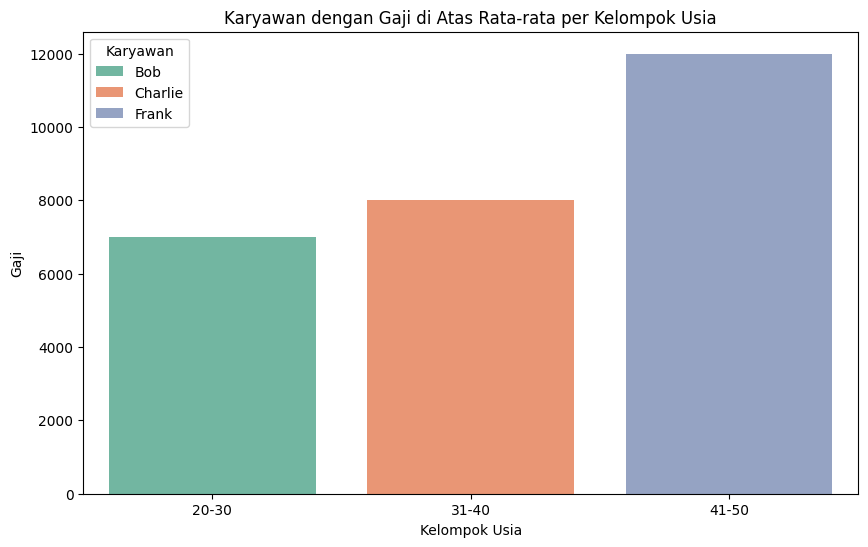

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi dengan grafik batang
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='salary', hue='name', data=df_above_avg, palette='Set2')

plt.title('Karyawan dengan Gaji di Atas Rata-rata per Kelompok Usia')
plt.ylabel('Gaji')
plt.xlabel('Kelompok Usia')
plt.legend(title='Karyawan')
plt.show()

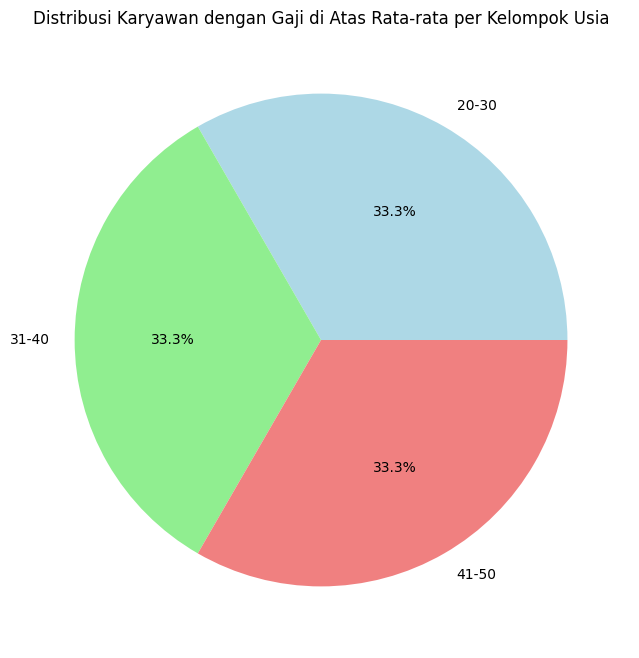

In [ ]:
# Visualisasi dengan pie chart
plt.figure(figsize=(8, 8))
df_above_avg['age_group'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'])

plt.title('Distribusi Karyawan dengan Gaji di Atas Rata-rata per Kelompok Usia')
plt.ylabel('')
plt.show()

## Tugas 3

In [27]:
import pandas as pd
import numpy as np

# Membuat dataset besar
np.random.seed(42)
employee_ids = np.arange(1, 101)
names = np.random.choice(['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Frank', 'Grace', 'Hannah', 'Ivy', 'Jack'], size=100)
age_groups = np.random.choice(['20-30', '31-40', '41-50', '51-60'], size=100)
salaries = np.random.randint(3000, 15000, size=100)
departments = np.random.choice(['IT', 'Finance', 'HR', 'Sales', 'Marketing'], size=100)

df_employees = pd.DataFrame({
    'employee_id': employee_ids,
    'name': names,
    'age_group': age_groups,
    'salary': salaries,
    'department': departments
})

df_employees.head()

,employee_id,name,age_group,salary,department
0,1,Grace,51-60,3663,HR
1,2,David,31-40,4998,Sales
2,3,Hannah,20-30,10994,IT
3,4,Eve,51-60,14637,Sales
4,5,Grace,41-50,14935,HR


In [ ]:
# Tabel departemen
department_data = {
    'department_id': [1, 2, 3, 4, 5],
    'department_name': ['IT', 'Finance', 'HR', 'Sales', 'Marketing'],
    'location': ['New York', 'London', 'Tokyo', 'Berlin', 'Paris']
}

df_departments = pd.DataFrame(department_data)
df_departments.head()

,department_id,department_name,location
0,1,IT,New York
1,2,Finance,London
2,3,HR,Tokyo
3,4,Sales,Berlin
4,5,Marketing,Paris


In [ ]:
# Menggunakan fungsi SUM() untuk menghitung total gaji per departemen
df_salary_by_dept = df_employees.groupby('department')['salary'].sum().reset_index()
df_salary_by_dept.columns = ['department', 'total_salary']
df_salary_by_dept

,department,total_salary
0,Finance,156234
1,HR,182088
2,IT,206603
3,Marketing,149131
4,Sales,212544


In [ ]:
# Menggunakan fungsi AVG() untuk rata-rata gaji per kelompok usia
df_avg_salary_by_age = df_employees.groupby('age_group')['salary'].mean().reset_index()
df_avg_salary_by_age.columns = ['age_group', 'avg_salary']
df_avg_salary_by_age

,age_group,avg_salary
0,20-30,9684.461538
1,31-40,8008.571429
2,41-50,9460.032258
3,51-60,8789.227273


In [ ]:
# Menggunakan fungsi COUNT() untuk menghitung jumlah karyawan per departemen
df_count_employees_by_dept = df_employees.groupby('department')['employee_id'].count().reset_index()
df_count_employees_by_dept.columns = ['department', 'num_employees']
df_count_employees_by_dept

,department,num_employees
0,Finance,17
1,HR,21
2,IT,24
3,Marketing,17
4,Sales,21


In [ ]:
# Melakukan operasi JOIN
df_merged = pd.merge(df_employees, df_departments, left_on='department', right_on='department_name')
df_merged.head()

,employee_id,name,age_group,salary,department,department_id,department_name,location
0,1,Grace,51-60,3663,HR,3,HR,Tokyo
1,2,David,31-40,4998,Sales,4,Sales,Berlin
2,3,Hannah,20-30,10994,IT,1,IT,New York
3,4,Eve,51-60,14637,Sales,4,Sales,Berlin
4,5,Grace,41-50,14935,HR,3,HR,Tokyo


<ipython-input-40-e62efe25a391>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='department', y='total_salary', data=df_salary_by_dept, palette='Set2')


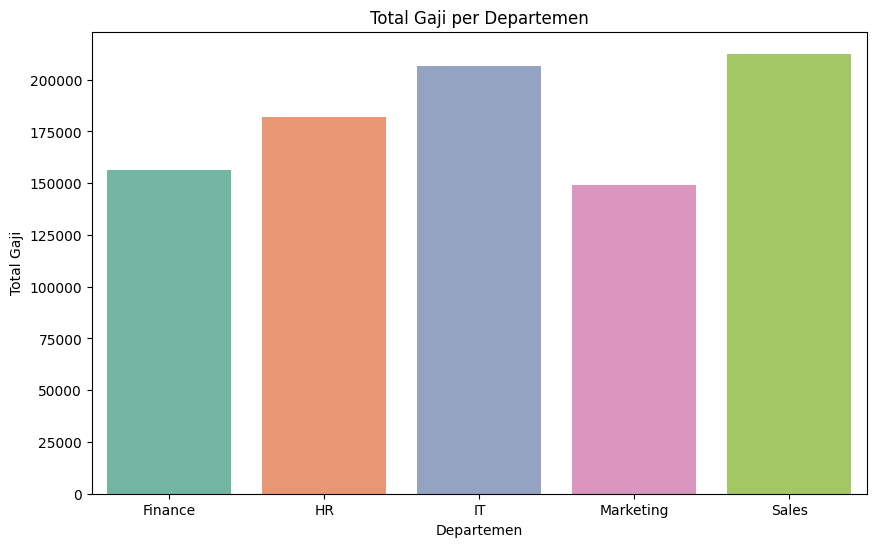

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi total gaji per departemen
plt.figure(figsize=(10, 6))
sns.barplot(x='department', y='total_salary', data=df_salary_by_dept, palette='Set2')

plt.title('Total Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Total Gaji')
plt.show()